In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt

from pycox.models import CoxPH
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import warnings
from sklearn.model_selection import KFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

np.random.seed(1234)
_ = torch.manual_seed(123)

In [37]:
class TransformerSurvival(nn.Module):
    def __init__(self, in_features, d_model=32, out_features=1, 
                 nhead=4, num_layers=2, dropout=0.1, batch_norm=True, output_bias=False):
        super().__init__()
        
        # Input projection - 将输入特征投影到Transformer的维度
        self.input_proj = nn.Linear(in_features, d_model)
        
        # Positional encoding - 位置编码
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Batch norm
        self.bn = nn.BatchNorm1d(d_model) if batch_norm else nn.Identity()
        
        # 直接输出层 - 从Transformer维度映射到输出维度
        self.output_layer = nn.Linear(d_model, out_features, bias=output_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        # Input processing
        x = self.input_proj(x)  # [batch_size, in_features] -> [batch_size, d_model]
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Transformer processing
        # 添加序列维度并加上位置编码
        x = x.unsqueeze(1)  # [batch_size, d_model] -> [batch_size, 1, d_model]
        x = x + self.pos_encoding
        
        # Transformer处理
        x = self.transformer(x)  # [batch_size, 1, d_model]
        
        # 移除序列维度并直接输出
        x = x.squeeze(1)  # [batch_size, 1, d_model] -> [batch_size, d_model]
        
        # 直接映射到输出
        return self.output_layer(x)


# 简洁的创建函数
def create_transformer_network(in_features, d_model=32, out_features=1, 
                              batch_norm=True, dropout=0.1, output_bias=False,
                              nhead=4, num_layers=2):
    """创建简化的Transformer生存网络（无中间输出层）"""
    return TransformerSurvival(
        in_features=in_features,
        d_model=d_model,
        out_features=out_features,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout,
        batch_norm=batch_norm,
        output_bias=output_bias
    )

In [38]:
import numpy as np
import pandas as pd

# 设置随机种子
np.random.seed(42)

# 参数
n = 2000       # 样本量
p = 20         # 变量个数

# 均值向量
mean = np.zeros(p)
rho = 0.9

# 协方差矩阵 Sigma
Sigma = np.zeros((p, p))
for j in range(p):
    for k in range(p):
        Sigma[j, k] = rho ** abs(j - k)

# 生成 X ~ N(0, Sigma)
X = np.random.multivariate_normal(mean, Sigma, size=n)

# 风险函数 h(x) = exp(-x1^2 - x2^2)
# 对应的Cox比例风险模型 hazard = h(x) * λ0(t)
lin_pred = X[:, 0]*X[:, 19] + X[:, 5]*X[:, 15]
hazard_ratio = np.exp(lin_pred)   # 相对风险

# 基线风险 λ0(t) 设为 1（指数分布）
# 生成生存时间: T ~ Exp(λ0 * hazard_ratio)
# 生存时间公式：T = -ln(U) / (λ0 * hazard_ratio)，U ~ Uniform(0,1)
U = np.random.uniform(size=n)
T = -np.log(U) / hazard_ratio

# 生成独立删失时间 C ~ Exp(λc)，控制删失率
lambda_c = 0.1
C = np.random.exponential(scale=1/lambda_c, size=n)

# 观测时间与删失指示
time = np.minimum(T, C)
event = (T <= C).astype(int)

# 组织成 DataFrame
df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(p)])
df["duration"] = time
df["event"] = event

print(df.head())
print("删失率:", 1 - df["event"].mean())

         x1        x2        x3        x4        x5        x6        x7  \
0  0.794694  0.593889 -0.129780 -0.186044 -0.970892 -0.540572 -0.418436   
1 -1.173869 -1.200335 -0.537824 -1.054744 -1.026435 -0.509589 -1.044244   
2  0.050895 -0.457233 -1.049594 -0.983724 -0.623952 -0.938471 -0.820918   
3 -0.886613 -0.091204 -0.533159  0.197299  1.298603  1.139557  0.786187   
4  0.651648  0.639462  0.454022 -0.197766 -0.232900  0.176485 -0.057401   

         x8        x9       x10  ...       x13       x14       x15       x16  \
0 -0.657065 -1.244734 -0.821896  ...  0.046575  0.041621 -0.368506 -0.072045   
1 -1.067798 -0.863523 -0.670997  ... -1.529070 -1.943339 -1.886819 -1.709197   
2 -0.786451  0.002704 -0.229481  ... -0.827961 -0.963281 -0.760717 -1.008640   
3  0.986110  0.317374  0.969108  ...  0.639061  0.486436 -0.384276  0.022520   
4  0.087307 -0.074445 -0.436590  ... -0.051831 -0.072348 -0.181499  0.503773   

        x17       x18       x19       x20  duration  event  
0 -0.54

In [39]:
cols_standardize = [f'x{i}' for i in range(1,21)]
standardize = [([col], StandardScaler()) for col in cols_standardize]
x_mapper = DataFrameMapper(standardize)

In [40]:
# 设置重复次数和折数
n_repeats = 100
n_folds = 5
total_runs = n_repeats * n_folds
batch_size = 256
epochs = 200

# 初始化结果存储
cindex = np.zeros((total_runs, 5))
ibs = np.zeros((total_runs, 5))

print(f"开始进行 {n_repeats} 次重复的 {n_folds} 折交叉验证，总共 {total_runs} 次运行...")
j=-1
for repeat in range(n_repeats):
    if repeat%10==0:
        print(f"第 {repeat + 1}/{n_repeats} 次重复...")
    
    # 每次重复时随机打乱数据
    df_shuffled = df.sample(frac=1, random_state=repeat).reset_index(drop=True)
    
    # 初始化KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=repeat)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df_shuffled)):
        # 划分训练集和测试集
        j=j+1
        df_train = df_shuffled.iloc[train_idx]
        df_test = df_shuffled.iloc[test_idx]
        
        # 从训练集中划分验证集
        df_val = df_train.sample(frac=0.2, random_state=repeat)
        df_train = df_train.drop(df_val.index)
        
        # 数据预处理
        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')
        
        # 数据预处理 - 传统机器学习模型（使用所有训练数据）
        x_train_ml = x_mapper.fit_transform(df_train).astype('float32')
        x_test_ml = x_mapper.transform(df_test).astype('float32')
        
        get_target = lambda df: (df['duration'].values, df['event'].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        
        ## 专门为DeepHit设计，转换成离散时间
        num_durations = 100
        labtrans = DeepHitSingle.label_transform(num_durations)
        y_train2 = labtrans.fit_transform(*get_target(df_train))
        y_val2 = labtrans.transform(*get_target(df_val))
        train2 = (x_train, y_train2)
        val2 = (x_val, y_val2)
        
        val = (x_val, y_val)
        # 准备生存分析格式（用于Cox和RSF）
        def prepare_survival_data(df):
            return np.array([(row['event'], row['duration']) for _, row in df.iterrows()], 
                          dtype=[('event', '?'), ('time', '<f8')])
        
        y_train_surv = prepare_survival_data(df_train)
        y_test_surv = prepare_survival_data(df_test)
        
        callbacks1 = [tt.callbacks.EarlyStopping()]
        callbacks2 = [tt.callbacks.EarlyStopping()]
        callbacks3 = [tt.callbacks.EarlyStopping()]
        
        # 创建和训练模型
        net1 = create_transformer_network(
            in_features= x_train.shape[1],
            d_model=64,
            out_features=1,
            nhead=2,
            num_layers=1,
            dropout=0.1,
            batch_norm=True,
            output_bias=False
        )
        model1 = CoxPH(net1, tt.optim.Adam)
        model1.optimizer.set_lr(0.01)

        ## model 2
        net2 = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = 1, batch_norm = True,
                                      dropout = 0.1,  output_bias = False)
        model2 = CoxPH(net2, tt.optim.Adam)
        model2.optimizer.set_lr(0.01)
        
        ## model 3
        net3 = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = labtrans.out_features, 
                                      batch_norm = True, dropout = 0.1)
        model3 = DeepHitSingle(net3, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
        model3.optimizer.set_lr(0.01)
        
        # 模型4: Cox比例风险模型
        cox_model = CoxPHSurvivalAnalysis()
        
        # 模型5: 随机生存森林
        rsf_model = RandomSurvivalForest(
            n_estimators=100,
            min_samples_split=10,
            min_samples_leaf=15,
            max_features="sqrt",
            n_jobs=-1,
            random_state=repeat
        )
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning, module="torchtuples")
            log1 = model1.fit(x_train, y_train, batch_size, epochs, callbacks1, False,
                          val_data=val, val_batch_size=batch_size)
            log2 = model2.fit(x_train, y_train, batch_size, epochs, callbacks2, False,
                          val_data=val, val_batch_size=batch_size)
            log3 = model3.fit(x_train, y_train2, batch_size, epochs, callbacks3, False, 
                              val_data=val2, val_batch_size=batch_size)
            # 训练传统机器学习模型
            cox_model.fit(x_train_ml, y_train_surv)
            rsf_model.fit(x_train_ml, y_train_surv)
            
        # 计算基线风险并预测
        time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
        ha1 = model1.compute_baseline_hazards()
        surv1 = model1.predict_surv_df(x_test)
        ha2 = model2.compute_baseline_hazards()
        surv2 = model2.predict_surv_df(x_test)
        
        ## DeepHit预测
        surv3 = model3.interpolate(num_durations).predict_surv_df(x_test)
        
        # Cox模型预测 - 插值到统一的时间网格
        cox_surv_fn = cox_model.predict_survival_function(x_test_ml)
        cox_max_time = min(fn.x[-1] for fn in cox_surv_fn)   # 每个 StepFunction 最后一个点
        time_grid1 = np.linspace(durations_test.min(), cox_max_time, 100)
        cox_surv = np.zeros((len(x_test_ml), len(time_grid1)))
        for i, fn in enumerate(cox_surv_fn):
            cox_surv[i] = np.array([fn(t) for t in time_grid1])
        surv4 = pd.DataFrame(cox_surv.T, index=time_grid1)
        
        # RSF模型预测 - 插值到统一的时间网格
        rsf_surv_fn = rsf_model.predict_survival_function(x_test_ml)
        rsf_max_time = min(fn.x[-1] for fn in rsf_surv_fn)   # 每个 StepFunction 最后一个点
        time_grid2 = np.linspace(durations_test.min(), rsf_max_time, 100)
        rsf_surv = np.zeros((len(x_test_ml), len(time_grid2)))
        for i, fn in enumerate(rsf_surv_fn):
            rsf_surv[i] = np.array([fn(t) for t in time_grid2])
        surv5 = pd.DataFrame(rsf_surv.T, index=time_grid2)

        # 评估模型
        ev1 = EvalSurv(surv1, durations_test, events_test, censor_surv='km')
        cindex[j,0] = ev1.concordance_td()
        ev2 = EvalSurv(surv2, durations_test, events_test, censor_surv='km')
        cindex[j,1] = ev2.concordance_td()
        ev3 = EvalSurv(surv3, durations_test, events_test, censor_surv='km')
        cindex[j,2] = ev3.concordance_td('antolini')
        ev4 = EvalSurv(surv4, durations_test, events_test, censor_surv='km')
        cindex[j,3] = ev4.concordance_td()
        ev5 = EvalSurv(surv5, durations_test, events_test, censor_surv='km')
        cindex[j,4] = ev5.concordance_td()
        
        ibs[j,0] = ev1.integrated_brier_score(time_grid)
        ibs[j,1] = ev2.integrated_brier_score(time_grid)
        ibs[j,2] = ev3.integrated_brier_score(time_grid)
        ibs[j,3] = ev4.integrated_brier_score(time_grid)
        ibs[j,4] = ev5.integrated_brier_score(time_grid)
        if j%50==0:
            print(f"  折 {fold + 1}/{n_folds} - C-index1: {cindex[j,0]:.4f}, C-index2: {cindex[j,1]:.4f},  C-index3: {cindex[j,2]:.4f}, C-index4: {cindex[j,3]:.4f}, C-index5: {cindex[j,4]:.4f}")
            print(f"  折 {fold + 1}/{n_folds} - IBS1: {ibs[j,0]:.4f}, IBS2: {ibs[j,1]:.4f},  IBS3: {ibs[j,2]:.4f},  IBS4: {ibs[j,3]:.4f},  IBS5: {ibs[j,4]:.4f}")

# 计算平均指标
mean_cindex = np.mean(cindex, axis=0)
mean_ibs = np.mean(ibs, axis=0)
std_cindex = np.std(cindex, axis=0)
std_ibs = np.std(ibs, axis=0)

print(f"\n最终结果 (基于 {total_runs} 次运行):")
print(f"模型1- Concordance Index: {mean_cindex[0]:.4f}")
print(f"模型2- Concordance Index: {mean_cindex[1]:.4f}")
print(f"模型3- Concordance Index: {mean_cindex[2]:.4f}")
print(f"模型4- Concordance Index: {mean_cindex[3]:.4f}")
print(f"模型5- Concordance Index: {mean_cindex[4]:.4f}")
print(f"模型1- Integrated Brier Score: {mean_ibs[0]:.4f}")
print(f"模型2- Integrated Brier Score: {mean_ibs[1]:.4f}")
print(f"模型3- Integrated Brier Score: {mean_ibs[2]:.4f}")
print(f"模型4- Integrated Brier Score: {mean_ibs[3]:.4f}")
print(f"模型5- Integrated Brier Score: {mean_ibs[4]:.4f}")

开始进行 100 次重复的 5 折交叉验证，总共 500 次运行...
第 1/100 次重复...
  折 1/5 - C-index1: 0.7437, C-index2: 0.7344,  C-index3: 0.6646, C-index4: 0.4659, C-index5: 0.6127
  折 1/5 - IBS1: 0.0351, IBS2: 0.0243,  IBS3: 0.0406,  IBS4: 0.0455,  IBS5: 0.0384
第 11/100 次重复...
  折 1/5 - C-index1: 0.7762, C-index2: 0.7813,  C-index3: 0.6582, C-index4: 0.4881, C-index5: 0.6440
  折 1/5 - IBS1: 0.0577, IBS2: 0.0568,  IBS3: 0.0679,  IBS4: 0.0829,  IBS5: 0.0700
第 21/100 次重复...
  折 1/5 - C-index1: 0.7444, C-index2: 0.7369,  C-index3: 0.6355, C-index4: 0.5050, C-index5: 0.6047
  折 1/5 - IBS1: 0.0452, IBS2: 0.0475,  IBS3: 0.0544,  IBS4: 0.0655,  IBS5: 0.0574
第 31/100 次重复...
  折 1/5 - C-index1: 0.7543, C-index2: 0.7459,  C-index3: 0.6699, C-index4: 0.4912, C-index5: 0.6409
  折 1/5 - IBS1: 0.0303, IBS2: 0.0275,  IBS3: 0.0363,  IBS4: 0.0413,  IBS5: 0.0353
第 41/100 次重复...
  折 1/5 - C-index1: 0.7355, C-index2: 0.7355,  C-index3: 0.6641, C-index4: 0.5257, C-index5: 0.6622
  折 1/5 - IBS1: 0.0302, IBS2: 0.0288,  IBS3: 0.0401,  IBS

In [41]:
# Mean_cindex = np.zeros((5, 5))
# Mean_ibs = np.zeros((5, 5))

In [42]:
j=4
Mean_cindex[j,:] = mean_cindex
Mean_ibs[j,:] = mean_ibs
print(Mean_cindex)
print(Mean_ibs)

[[0.72505048 0.70518623 0.64399577 0.50808104 0.56144179]
 [0.72806305 0.71048999 0.65198059 0.50008704 0.55752588]
 [0.72905317 0.71303204 0.65782921 0.49727897 0.56370124]
 [0.73374325 0.71981696 0.66958078 0.50001649 0.57144163]
 [0.75186103 0.7473905  0.65191596 0.49806995 0.60914629]]
[[0.04485476 0.04831134 0.0568748  0.0629244  0.05849002]
 [0.04202555 0.04492013 0.05570897 0.06251329 0.05848996]
 [0.03926511 0.04151968 0.05316308 0.05915857 0.05496557]
 [0.03774538 0.03849445 0.04877054 0.05571076 0.05010469]
 [0.03529883 0.0351824  0.04702869 0.05244498 0.04540513]]


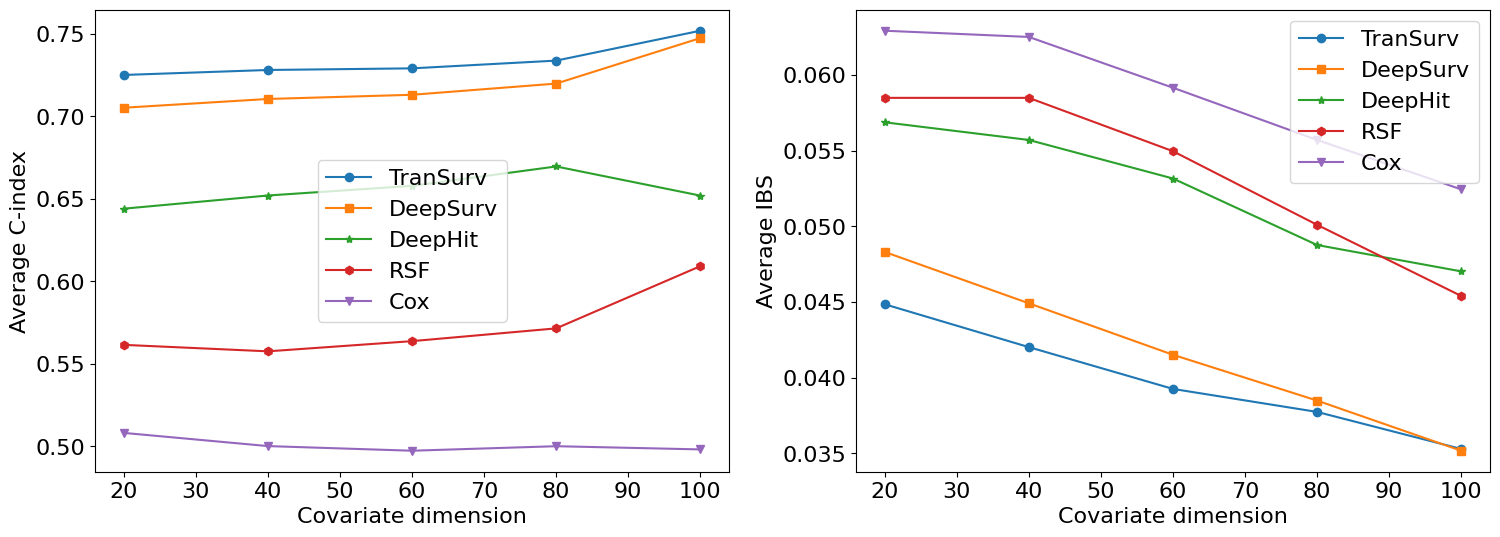

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.figure(figsize=(18,6))  
X = range(5)
X = [(x + 1)*20 for x in X]  # [1, 2, 3, 4, 5]
plt.subplot(1,2,1) 
plt.plot(X, Mean_cindex[:,0], marker='o',label='TranSurv')
plt.plot(X, Mean_cindex[:,1], marker='s',label='DeepSurv')
plt.plot(X, Mean_cindex[:,2], marker='*',label='DeepHit')
plt.plot(X, Mean_cindex[:,4], marker='h',label='RSF')
plt.plot(X, Mean_cindex[:,3], marker='v',label='Cox')
plt.xlabel('Covariate dimension')
plt.ylabel('Average C-index')
plt.legend()
plt.subplot(1,2,2) 
plt.plot(X, Mean_ibs[:,0], marker='o',label='TranSurv')
plt.plot(X, Mean_ibs[:,1], marker='s',label='DeepSurv')
plt.plot(X, Mean_ibs[:,2], marker='*',label='DeepHit')
plt.plot(X, Mean_ibs[:,4], marker='h',label='RSF')
plt.plot(X, Mean_ibs[:,3], marker='v',label='Cox')
plt.xlabel('Covariate dimension')
plt.ylabel('Average IBS')
plt.legend()
plt.subplots_adjust(wspace=0.2)
# plt.savefig('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/HD/HD-2025.09.02.pdf')

In [48]:
np.savetxt('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/DC/Mean_cindex-2025.09.03.csv', Mean_cindex, delimiter=',')
np.savetxt('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/DC/Mean_ibs-2025.09.03.csv', Mean_ibs, delimiter=',')